In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

#from data import loader_train, loader_val, loader_test
from train import train_model, test_model
from models import getModels
from utils import show_img
from trainers import Regression, Classification, BinaryClassification
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
from medmnist import PneumoniaMNIST

from torch.utils.data import Subset

transfomrms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_dataset = PneumoniaMNIST(split="test",transform= transfomrms, download=True,size=224)
train_dataset = PneumoniaMNIST(split="train", transform= transfomrms,download=True,size=224)
val_dataset = PneumoniaMNIST(split="val",transform=transfomrms, download=True,size=224)

# Definir el tamaño del subconjunto que deseas usar (por ejemplo, 10%)
subset_size = int(0.1 * len(train_dataset))

# Crear subconjuntos con índices aleatorios
train_indices = torch.randperm(len(train_dataset))[:subset_size]
val_indices = torch.randperm(len(val_dataset))[:subset_size*2]
test_indices = torch.randperm(len(test_dataset))[:subset_size*2]

# Crear los subconjuntos utilizando los índices seleccionados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

Using downloaded and verified file: C:\Users\34658\.medmnist\pneumoniamnist_224.npz
Using downloaded and verified file: C:\Users\34658\.medmnist\pneumoniamnist_224.npz
Using downloaded and verified file: C:\Users\34658\.medmnist\pneumoniamnist_224.npz


In [3]:
# start a new wandb run to track this script
import wandb
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="Test",
    name="MyComputer - Tests",

    # track hyperparameters and run metadata
    config={
        "N_images" : 1,
        "learning_rate": 0.001,
        "dataset": "Expert 1",
        "epochs": 50,
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chermar (chermar-universitat-polit-cnica-de-val-ncia). Use `wandb login --relogin` to force relogin


In [4]:
import os
import sys
sys.path.append("..")


loader_train = DataLoader(train_subset, batch_size=32, shuffle=True)
loader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
loader_test = DataLoader(test_subset, batch_size=32, shuffle=True)

In [5]:
batch = next(iter(loader_train))

print(batch[0].shape)

torch.Size([32, 1, 224, 224])


In [6]:
from resnet18 import ResNet, BasicBlock

In [7]:
from torch import nn
class CustomModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.classes = num_classes

        self._embeed = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) # 224
        )

        self._block1 = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(224, 224)
                )
                for i in range(1)
            ]
        )


        self._final = nn.Sequential(
            nn.Linear(64 * 224 * 224, num_classes)
        )

    def forward(self, x):
        x = self._embeed(x)

        for block in self._block1:
            x = block(x)
        x = x.view(x.size(0), -1)
        x = self._final(x)
        return x


In [8]:
batch = next(iter(loader_train))

x, y = batch

print(x.shape)
conv2d = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
x_out = conv2d(x)
print(x_out.shape)

torch.Size([32, 1, 224, 224])
torch.Size([32, 64, 224, 224])


 Epoch: 0, Phase: train,  ACC: 0.81, AUC: 0.89


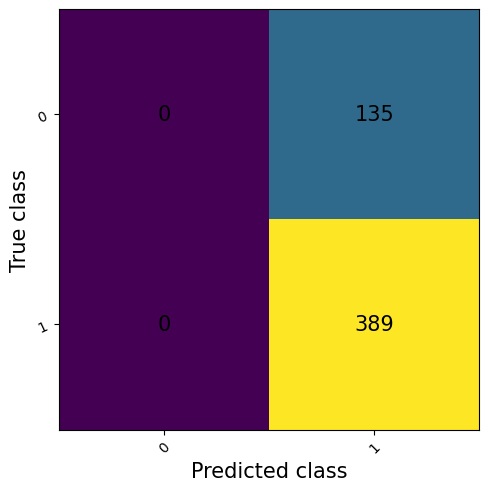

 Epoch: 0, Phase: val,  ACC: 0.74, AUC: 0.62
 Epoch: 1, Phase: train,  ACC: 0.89, AUC: 0.70


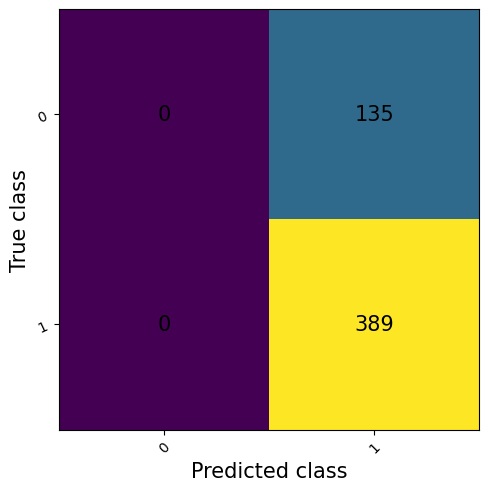

 Epoch: 1, Phase: val,  ACC: 0.74, AUC: 0.63
Test model ResNet - Loss: 7.32, ACC: 0.62, AUC: 0.56


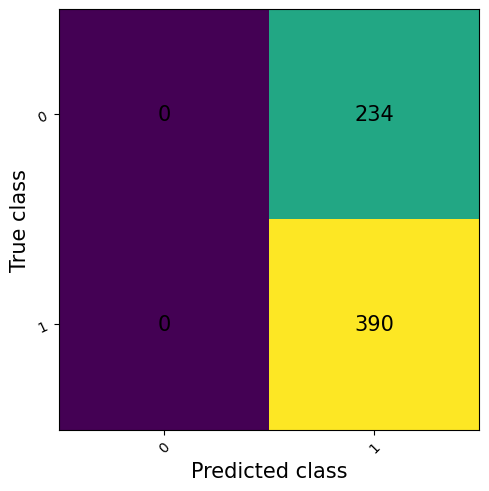

In [9]:
#train a model
model =  ResNet(img_channels=1, num_layers=18, block=BasicBlock, num_classes=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = BinaryClassification(model, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, loader_train, loader_val, trainer, optimizer, device, num_epochs=2, classification = True)
test_model(model, loader_test, trainer, device, classification = True)

Test model ResNet - Loss: 7.31, ACC: 0.62, AUC: 0.53


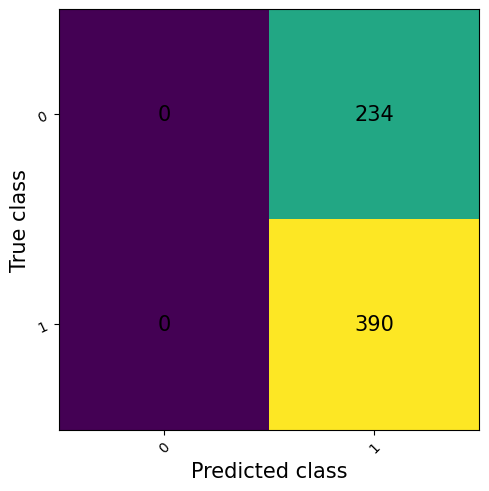

In [10]:
test_model(model, loader_test, trainer, device, classification = True)